# <center>Is constructing a portfolio from underperforming actively managed funds a viable investment strategy?</center>

<center>BMF5324 Statistics and Analytics in Finance</center>



**<center> Section Group 1 Group 11 </center>**
<center>Luca Triglia</center>



_Note to Prof: running this program as it is will result in errors as it is trying to connect to the refinitiv platform to extract data. Ignoring these errors and running the rest of the code will still work as per normal!_

## 1. Preparation

### Imports and Installations:

In [1]:
# !pip install Eikon
import eikon as ek
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions
from pypfopt.risk_models import CovarianceShrinkage

import pingouin as pg

start_date = dt.datetime(2016,8,30)
end_date = dt.datetime(2022,8,31)

periods = ['period16_18', 'period17_19', 'period18_20', 'period19_21']
period_start_dates = ['2016-08-31', '2017-08-31', '2018-08-31', '2019-08-31']
period_end_dates = ['2018-08-31', '2019-08-31', '2020-08-31', '2021-08-31']

period_start_dates_backtesting = ['2018-08-31', '2019-08-31', '2020-08-31', '2021-08-31']
period_end_dates_backtesting = ['2019-08-31', '2020-08-31', '2021-08-31', '2022-08-31']

trading_days_per_year = 252

### Connect to Refinitiv API

In [2]:
# Connect to the Refinitiv Platform using API key
ek.set_app_key('8f28279a9d2141a09d1e72c755a9ca34ff7b46b6')

2022-11-08 22:55:40,076 P[14399] [MainThread 8664871616] Error: no proxy address identified.
Check if Eikon Desktop or Eikon API Proxy is running.
2022-11-08 22:55:40,077 P[14399] [MainThread 8664871616] Port number was not identified, cannot send any request
2022-11-08 22:55:40,077 P[14399] [MainThread 8664871616] Port number was not identified.
Check if Eikon Desktop or Eikon API Proxy is running.
/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


EikonError: Error code -1 | Port number was not identified. Check if Eikon Desktop or Eikon API Proxy is running.

## 2. Fund selection

### Multi-factor Model

- The capital asset pricing model (CAPM) with market factor (MKT)
- The Fama-French three factor model with market, size, and value factors (MKT, SMB, HML)
- The Carhart four-factor model with market, size, value, and momentum factors (MKT, SMB, HML, MOM)
- The Fama-French five factor model with market, size, value, profitability, and investment factors (MKT, SMB, HML, RMW, CMA)


#### Factors Analysis

- $\text{Mkt-RF}$ is excess return of a broad market over the risk-free rate ($R_m - R_f$) (**market factor**) 

- $\text{SMB}$ is the average return on the *small* stock portfolios minus *big* stock portfolios (**size factor**) 

- $\text{HML}$ is the average return on *high* book value portfolios minus *low* book value (**value factor**)  
- $\text{MOM}$ is the momentum factor, which can be can be calculated by subtracting the equal weighted average of the lowest performing firms from the equal weighed average of the highest performing firms, lagged one month (**momentum factor**)

- $\text{RMW}$ is the average return on *robust* minus *weak* operating profitability portfolios (**profitability factor**) 

- $\text{CMA}$ Conservative minus aggresive investments, proxied by the y/y growth in company asset value (**investment factor**)

### Prepare the Factor DataFrame

In [7]:
# Read the Fama/French 5 research Factors csv file with pd.read_csv()
factor_returns = pd.read_csv('Data/FF_Research_Data_5_Factors_2x3_daily.CSV',parse_dates=['Date'], index_col = 'Date')
# Read the momentum factor csv file with pd.read_csv()
mom_factor = pd.read_csv('Data/FF_Momentum_Factor_daily.CSV', parse_dates=['Date'], index_col = 'Date')

# Convert the 'Date' column into a series of datetime objects
#factor_returns['Date'] = pd.to_datetime(factor_returns['Date'], format='%Y%m%d')
#mom_factor['Date'] = pd.to_datetime(mom_factor['Date'], format='%Y%m%d')

# Set the 'Date' column as the index of the DataFrames
#factor_returns.set_index('Date', inplace = True)
#mom_factor.set_index('Date', inplace = True)

# Merge the momentum factor dataframe with the other 5 factors
factor_returns = pd.merge(factor_returns, mom_factor, left_index = True, right_index = True, how = 'inner')

# Swap the momentum column and the RF column
factor_returns = factor_returns[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom', 'RF']]

# Divide all columns (Excluding Risk Free Rate) by 100
factor_returns.iloc[:,:-1] = factor_returns.iloc[:,:-1] / 100
# Inspect the DataFrame
factor_returns.tail()

,Mkt-RF,SMB,HML,RMW,CMA,Mom,RF
Date,,,,,,,
2022-08-25,0.0145,0.0014,-0.0001,0.0012,-0.0041,-0.0077,0.008
2022-08-26,-0.0338,-0.0028,0.0169,0.0024,0.0087,0.0195,0.008
2022-08-29,-0.0072,-0.0038,0.0042,0.0023,0.0042,0.0062,0.008
2022-08-30,-0.0111,-0.0038,-0.0024,-0.0024,0.0012,-0.0086,0.008
2022-08-31,-0.0074,0.0022,-0.0044,-0.0063,-0.0012,-0.0026,0.008


### Refinitiv Retreival Function

In [8]:
def retreive_refinitiv_data(funds, start_date, end_date):
    
    etf_dataframe = pd.DataFrame()
    
    for fund in funds:
        try:
            etf_dataframe[fund] = ek.get_timeseries([fund], interval = 'daily', start_date = start_date, end_date = end_date)['CLOSE']
        except Exception as e:
            pass   
        continue
    return etf_dataframe

In [9]:
def excel_one_line_to_list(filename):
    df = pd.read_excel(filename, usecols=[0], names=None) 
    df_li = df.values.tolist()
    result = []
    for s_li in df_li:
        result.append(s_li[0])    
    return result

ETFRIC = excel_one_line_to_list("Data/ETFlist.xlsx")

In [12]:
etfsummary,err = ek.get_data(ETFRIC,
                      fields= ['TR.CompanyName','TR.FundLaunchDate','TR.ISIN', 'TR.FundType',
                               'TR.FundBenchmarkType','TR.FundBenchmarkName',
                               'TR.Fund5YearPerf','TR.FundAlpha5Year','TR.FundBeta5Year','TR.FundRSq5Year','TR.FundStdDev5Year','TR.FundSharpe5Year',
                               'TR.FundMaxDrawDown5Year','TR.FundTreynor5Year','TR.FundNAV','TR.FundRollingPerformance'])

AttributeError: 'NoneType' object has no attribute '_uri_reference'

In [14]:
from mitosheet import *; register_analysis("id-yapklmsyzd");
    
# Sorted Launch Date in ascending order
etfsummary = etfsummary.sort_values(by='Launch Date', ascending=True, na_position='first')

# Deleted 1 row in etfsummary
etfsummary.drop(labels=[319], inplace=True)

# Changed Launch Date to dtype datetime
import pandas as pd
#etfsummary['Launch Date'] = pd.to_datetime(etfsummary['Launch Date'], infer_datetime_format=True, errors='coerce')

# Filtered Launch Date
#etfsummary = etfsummary[etfsummary['Launch Date'] <= pd.to_datetime('2016-08-30')]


NameError: name 'etfsummary' is not defined

In [15]:
ETFRIC_filter = etfsummary['Instrument'].values.tolist()

NameError: name 'etfsummary' is not defined

In [16]:
# etfsprice = retreive_refinitiv_data(ETFRIC_filter, start_date, end_date)

In [17]:
# download the data for further use
## take too much time to retreive refinitiv data every time...
# etfsprice.to_csv('ETFprice_filter.csv')
etfsprice = pd.read_csv('Data/ETFprice_filter.csv', parse_dates=['Date'], index_col = 'Date')

In [18]:
etfsreturn_raw = etfsprice.pct_change()[1:]

### Data cleaning

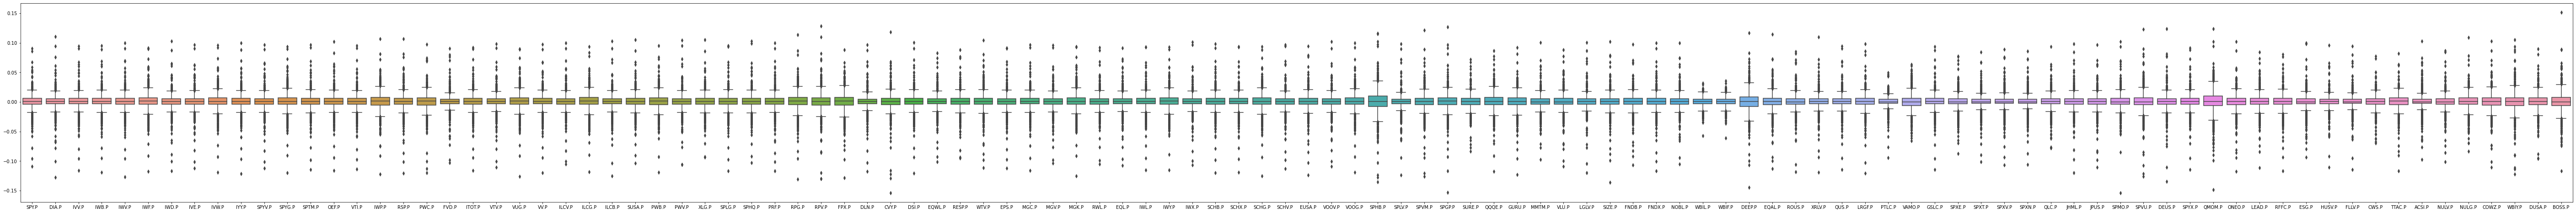

,SPY.P,DIA.P,IVV.P,IWB.P,IWV.P,IWF.P,IWD.P,IVE.P,IVW.P,IYY.P,...,FLLV.P,CWS.P,TTAC.P,ACSI.P,NULV.P,NULG.P,COWZ.P,WBIY.P,DUSA.P,BOSS.P
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,...,1495.000000,1496.000000,1491.000000,1467.000000,1437.000000,1437.000000,1434.000000,1431.000000,1418.000000,1394.000000
mean,0.000467,0.000432,0.000470,0.000466,0.000460,0.000629,0.000300,0.000326,0.000589,0.000459,...,0.000449,0.000440,0.000499,0.000482,0.000284,0.000586,0.000505,0.000174,0.000320,0.000489
std,0.012089,0.012303,0.012274,0.012296,0.012497,0.013772,0.012056,0.011865,0.013497,0.012308,...,0.010983,0.011112,0.012144,0.012017,0.011648,0.013807,0.013741,0.015752,0.013299,0.016461
min,-0.109424,-0.127612,-0.115743,-0.119059,-0.126653,-0.117884,-0.116966,-0.111856,-0.118804,-0.121071,...,-0.114469,-0.069767,-0.116610,-0.097617,-0.101213,-0.083869,-0.110924,-0.121891,-0.095760,-0.116795
25%,-0.003548,-0.003533,-0.003447,-0.003509,-0.003733,-0.004235,-0.003685,-0.003829,-0.004067,-0.003606,...,-0.002746,-0.004194,-0.004436,-0.002597,-0.003691,-0.004297,-0.005242,-0.006555,-0.004991,-0.006262
50%,0.000655,0.000738,0.000715,0.000739,0.000772,0.001279,0.000605,0.000642,0.001004,0.000733,...,0.000000,0.000627,0.001107,0.000000,0.000307,0.000614,0.000819,0.000490,0.000821,0.000000
75%,0.005920,0.005441,0.005830,0.006058,0.005943,0.007004,0.005309,0.005377,0.006623,0.005844,...,0.004449,0.005582,0.006608,0.004382,0.005208,0.007236,0.006937,0.007187,0.007008,0.008052
max,0.090603,0.110192,0.094503,0.094804,0.099338,0.091317,0.102853,0.096902,0.095415,0.099982,...,0.094237,0.077108,0.081727,0.102698,0.086584,0.109019,0.103049,0.105224,0.089965,0.151683


In [19]:
etfsreturn_raw = etfsreturn_raw.dropna(thresh = len(etfsreturn_raw)* 0.9, axis=1)
import seaborn as sns
f,ax=plt.subplots(figsize=(100,8))
sns.boxplot(data=etfsreturn_raw)
plt.show()
etfsreturn_raw.describe()

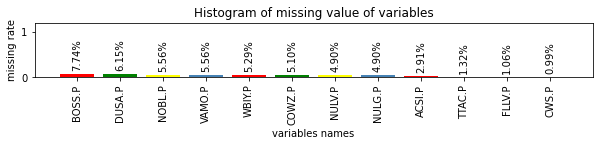

In [20]:
# Handle the NaN
import pandas as pd
# Count the number of missing values
missing=etfsreturn_raw.isnull().sum().reset_index().rename(columns={0:'missNum'})
# Calculate the missing rate
missing['missRate']=missing['missNum']/etfsreturn_raw.shape[0]
# Sort by missing rate
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)
# miss_analy stores a data frame for each variable missing

import matplotlib.pyplot as plt
import pylab as pl
fig = plt.figure(figsize=(10,1))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=['red','green','yellow','steelblue'])
plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)
for x,y in enumerate(list(miss_analy.missRate.values)):    
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    plt.ylim([0,1.2])
plt.show()

In [21]:
# Drop ones that have more than 20 NaN
drop_ones = miss_analy[miss_analy['missNum'] >= 100]['index'].tolist()
etfs_1 = etfsreturn_raw.drop(drop_ones, axis=1)
# Replace NaN with the latter value
etfs = etfs_1.fillna(method='backfill')
etfs.loc[:, etfs.isnull().any()].columns

Index([], dtype='object')

### Choose most appropriate model to retrive alpha

In [22]:
df = pd.merge(etfs, factor_returns, left_index = True, right_index = True, how = 'inner')

In [23]:
def model_choose(ETFreturn, df):
    # factors_camp = ['Mkt-RF']
    # factors_3 = ['Mkt-RF', 'SMB', 'HML']
    # factors_4 = ['Mkt-RF', 'SMB', 'HML', 'Mom']
    # factors_5 = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
    # model_types = ['camp', '3', '4', '5']
    
    result_camp = sm.OLS((ETFreturn - df['RF']).astype(float),
                         sm.add_constant(df['Mkt-RF'].astype(float))).fit()
    result_3factors = sm.OLS((ETFreturn - df['RF']).astype(float), 
                             sm.add_constant(df[['Mkt-RF', 'SMB', 'HML']].astype(float))).fit()
    result_4factors = sm.OLS((ETFreturn - df['RF']).astype(float), 
                             sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'Mom']].astype(float))).fit()
    result_5factors = sm.OLS((ETFreturn - df['RF']).astype(float), 
                             sm.add_constant(df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']].astype(float))).fit()

    results = [result_camp, result_3factors, result_4factors, result_5factors]
    p = 0
    alpha = 0
    r2 = results[0].rsquared_adj
    for i in range(len(results)):    
        if results[i].pvalues['const'] <= 0.01: 
            if results[i].rsquared_adj >= r2:
                r2 = results[i].rsquared_adj
                p = results[i].pvalues
                alpha = results[i].params[0]
    
    return alpha, r2, p

In [24]:
def get_alpha(df, start_date, end_date):  
    alphaline = pd.DataFrame(np.zeros(109)).T
    alphaline.columns = etfs.columns
    alphaline.index = ['alpha'+ start_date]
    for etf in etfs.columns:
        alphaline[etf] = model_choose(etfs[start_date:end_date][etf],df[start_date:end_date])[0]
    
    alphaline_T = alphaline.T
    alphaline_T.sort_values(by = 'alpha'+start_date, ascending=True, inplace = True)
    alphaline_T = alphaline_T.reset_index()
    return alphaline_T

In [25]:
alpha16_18 = get_alpha(df, '2016-08-31', '2018-08-31')
alpha17_19 = get_alpha(df, '2017-08-31', '2019-08-31')
alpha18_20 = get_alpha(df, '2018-08-31', '2020-08-31')
alpha19_21 = get_alpha(df, '2019-08-31', '2021-08-31')

In [26]:
result = pd.concat([alpha16_18, alpha17_19, alpha18_20, alpha19_21], axis=1)
result

,index,alpha2016-08-31,index,alpha2017-08-31,index,alpha2018-08-31,index,alpha2019-08-31
0,NOBL.P,-0.004649,VAMO.P,-0.007583,DEEP.P,-0.007215,WBIY.P,-0.002522
1,NULV.P,-0.004578,ONEO.P,-0.007499,VAMO.P,-0.007031,SPLV.P,-0.002499
2,VAMO.P,-0.004338,PWV.P,-0.007471,WBIF.P,-0.006917,DEEP.P,-0.002476
3,WBIY.P,-0.004280,LRGF.P,-0.007465,PTLC.P,-0.006904,CVY.P,-0.002415
4,IWD.P,-0.004097,PWC.P,-0.007450,RPV.P,-0.006842,HUSV.P,-0.002359
...,...,...,...,...,...,...,...,...
104,SPXE.P,-0.003548,ESG.P,-0.007145,NULG.P,-0.006288,IWY.P,-0.001871
105,SPXV.P,-0.003493,NULG.P,-0.007136,LGLV.P,-0.006274,LEAD.P,-0.001835
106,CWS.P,-0.003423,LGLV.P,-0.007119,ACSI.P,-0.006251,VAMO.P,-0.001797
107,SPXN.P,-0.003412,CWS.P,-0.007043,ESG.P,-0.006238,NULG.P,-0.001787


### Choose the tickers to build our fund pool

In [27]:
tickers_top20 = result[:20] 
tickers_bottom20 = result[-20:]

In [28]:
tickers = pd.concat([tickers_top20, tickers_bottom20])
tickers.to_csv('tickers.csv')

In [29]:
# Read and clean up tickers data 
tickers = pd.read_csv('Data/tickers.csv', index_col = 0)
# Since the tickers data is already sorted from lowest to highest alpha, we can safely discard the alpha column for this part
tickers.drop(tickers.columns[[1,3,5,7]], axis = 1, inplace = True)
# Reset the index
tickers.reset_index(inplace = True, drop = True)
# Now we separate the dataframe into two (lowest 20 alpha and highest 20 alpha)
tickers_btm20 = tickers.iloc[:20, :]
tickers_top20 = tickers.iloc[-20:, :]

# Finally, we create a dictionary which contains a list of tickers for each time period!
tickers_btm_20_dict = dict()
for idx, tickers in enumerate(tickers_btm20.T.to_numpy().tolist()):
    tickers_btm_20_dict[periods[idx]] = tickers
    
# Repeat for the top 20 alpha values
tickers_top_20_dict = dict()
for idx, tickers in enumerate(tickers_top20.T.to_numpy().tolist()):
    tickers_top_20_dict[periods[idx]] = tickers
    
# Testing: 
print(tickers_top_20_dict[periods[0]])

['DIA.P', 'WTV.P', 'ROUS.P', 'TTAC.P', 'WBIF.P', 'SPGP.P', 'DUSA.P', 'DEEP.P', 'FLLV.P', 'MMTM.P', 'SPMO.P', 'SPVU.P', 'VLU.P', 'SPXT.P', 'ESG.P', 'SPXE.P', 'SPXV.P', 'CWS.P', 'SPXN.P', 'COWZ.P']


In [30]:
# Read in etf prices and calculate returns
etf_prices = pd.read_csv('Data/ETFprice_filter.csv', parse_dates=['Date'], index_col = 'Date')
etf_returns = etf_prices.pct_change()[1:]

#initialise a list which will contain a dataframe of cumulative returns for each period
cum_returns_top20_data = list()
cum_returns_btm20_data = list()

for i in range(4):
    cum_returns_top20_data.append(pd.DataFrame())
    cum_returns_btm20_data.append(pd.DataFrame())

## Fund of Fund Construction

### Construct and Analyse the Portfolios 

In [31]:
def analyse_portfolio(weights, daily_returns, portfolio_type):
    
    # Print portfolio type
    print(portfolio_type + ":\n")
    
    # Calculate individual mean returns 
    daily_return_mean = daily_returns.mean()
    
    # Calculate expected portfolio performance
    daily_port_performance = np.sum(weights * daily_return_mean)

    # Calculate annual expected portfolio performance
    # There are 252 trading days in a year
    annualised_return = daily_port_performance * trading_days_per_year 

    # Print the portfolio return
    print("The annual expected portfolio return is: " + str(annualised_return))

    # Calculate the covariance matrix 
    cov_matrix = daily_returns.cov()
    # Calculate the portfolio variance
    port_variance = np.dot(weights.T, cov_matrix.dot(weights))

    # Calculate the standard deviation by taking the square root
    port_standard_dev = np.sqrt(port_variance)

    # Calculate the annualized portfolio standard deviation
    annualised_port_standard_dev = port_standard_dev * np.sqrt(trading_days_per_year)

    # Print the annualized portfolio standard deviation
    print("The annualised portfolio standard deviation is: " + str(annualised_port_standard_dev))

    # Assume the 10-year US Treasury yield as the risk-free rate
    # Snapshot at October 21, 2022
    risk_free = 0.042

    # Calculate the Sharpe ratio
    sharpe_ratio = (annualised_return - risk_free) / annualised_port_standard_dev

    # Print the Sharpe ratio of the portfolio
    print("The sharpe ratio of the portfolio is: " + str(sharpe_ratio))
    
    # Create portfolio daily returns
    daily_returns_new = daily_returns.copy()
    daily_returns_new['Portfolio'] = daily_returns_new.dot(weights)
    
    # Print the portfolio daily return mean
    print("\nThe portfolio daily return mean is: " + str(daily_returns_new['Portfolio'].mean()))

    # Print the portfolio daily return standard deviation
    print("The portfolio daily return  standard deviation is: " + str(daily_returns_new['Portfolio'].std()))

    # Print the portfolio daily return skewness 
    print("The portfolio daily return skewness is: " + str(daily_returns_new['Portfolio'].skew()))

    # Print the portfolio daily return kurtosis
    print("The portfolio daily return kurtosis is: " + str(daily_returns_new['Portfolio'].kurtosis()))
    
    # Calculate cumulative returns
    # Hint: Use .cumprod()
    daily_cum_return = (1 + daily_returns_new).cumprod()
    
    return daily_cum_return['Portfolio']

#### Equal Weight Portfolio

In [32]:
def equal_weight_portfolio(period_index):
    
    print("ANALYSING RETURNS FOR " + periods[period_index].upper() + "\n")
    
    weights = np.repeat(1/20, 20)
    
    # Filter the list of returns to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    
    # Call the analyse portfolio function
    cum_returns_top20 = analyse_portfolio(weights, etf_returns_top20_tmp, "TOP 20 ALPHA - EQUAL WEIGHT PORTFOLIO")
    
    print("")
    
    # Filter the list of returns to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    
    # Call the analyse portfolio function
    cum_returns_btm20 = analyse_portfolio(weights, etf_returns_btm20_tmp, "BOTTOM 20 ALPHA - EQUAL WEIGHT PORTFOLIO")
    
    print("\n***************************************\n")


    return cum_returns_top20, cum_returns_btm20

In [33]:
for period_index in range(4):
    cum_returns_top20, cum_returns_btm20 = equal_weight_portfolio(period_index)
    cum_returns_top20_data[period_index]['Equal Weight'] = cum_returns_top20
    cum_returns_btm20_data[period_index]['Equal Weight'] = cum_returns_btm20    

ANALYSING RETURNS FOR PERIOD16_18

TOP 20 ALPHA - EQUAL WEIGHT PORTFOLIO:

The annual expected portfolio return is: 0.16552589154538375
The annualised portfolio standard deviation is: 0.079279617961838
The sharpe ratio of the portfolio is: 1.5581040211980348

The portfolio daily return mean is: 0.0006703197190509479
The portfolio daily return  standard deviation is: 0.00516562363733763
The portfolio daily return skewness is: -1.082006756921347
The portfolio daily return kurtosis is: 4.6338707963647625

BOTTOM 20 ALPHA - EQUAL WEIGHT PORTFOLIO:

The annual expected portfolio return is: 0.09979790939083195
The annualised portfolio standard deviation is: 0.09383811892646877
The sharpe ratio of the portfolio is: 0.6159320972335581

The portfolio daily return mean is: 0.00038165407374571476
The portfolio daily return  standard deviation is: 0.0058956570408787694
The portfolio daily return skewness is: -1.2777051016478649
The portfolio daily return kurtosis is: 6.223860259747843

***********

#### Max Sharpe Portfolio

In [34]:
def get_max_sharpe_weights(prices):
    # Calculate expected returns mu 
    mu = expected_returns.mean_historical_return(prices)

    # Calculate the covariance matrix S
    S = risk_models.sample_cov(prices)

    # Obtain the efficient frontier
    ef = EfficientFrontier(mu,S)

    # Calculate weights for the maximum Sharpe ratio portfolio
    raw_weights_maxsharpe = ef.max_sharpe() 
    cleaned_weights_maxsharpe = ef.clean_weights()

    # Convert cleaned weights to a numpy array
    max_sharpe_weights_array = np.array(list(cleaned_weights_maxsharpe.values()))
            
    return max_sharpe_weights_array

In [35]:
def max_sharpe_portfolio(period_index):
    
    print("ANALYSING RETURNS FOR " + periods[period_index].upper() + "\n")
    
    # Filter the list of returns & prices to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    etf_prices_top20_tmp = etf_prices[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_top20_tmp = etf_prices_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    
    
    # Call the analyse portfolio function
    max_sharpe_weights_top20 = get_max_sharpe_weights(etf_prices_top20_tmp)
    cum_returns_top20 = analyse_portfolio(max_sharpe_weights_top20, etf_returns_top20_tmp, "TOP 20 ALPHA - MAX SHARPE")
    
    print("")
    
    # Filter the list of returns & prices to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    etf_prices_btm20_tmp = etf_prices[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_btm20_tmp = etf_prices_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]

    # Call the analyse portfolio function
    max_sharpe_weights_btm20 = get_max_sharpe_weights(etf_prices_btm20_tmp)
    cum_returns_btm20 = analyse_portfolio(max_sharpe_weights_btm20, etf_returns_btm20_tmp, "BOTTOM 20 ALPHA - MAX SHARPE")
    
    print("\n***************************************\n")


    return cum_returns_top20, cum_returns_btm20

In [36]:
for period_index in range(4):
    cum_returns_top20, cum_returns_btm20 = max_sharpe_portfolio(period_index)
    cum_returns_top20_data[period_index]['Max Sharpe'] = cum_returns_top20
    cum_returns_btm20_data[period_index]['Max Sharpe'] = cum_returns_btm20    

ANALYSING RETURNS FOR PERIOD16_18

TOP 20 ALPHA - MAX SHARPE:

The annual expected portfolio return is: 0.17398500608189146
The annualised portfolio standard deviation is: 0.06633689742116365
The sharpe ratio of the portfolio is: 1.9896168077312566

The portfolio daily return mean is: 0.0007614967736734686
The portfolio daily return  standard deviation is: 0.00436460002419418
The portfolio daily return skewness is: -0.23980646924527987
The portfolio daily return kurtosis is: 3.6674393943002035

BOTTOM 20 ALPHA - MAX SHARPE:

The annual expected portfolio return is: 0.13622245222721144
The annualised portfolio standard deviation is: 0.10207797328495287
The sharpe ratio of the portfolio is: 0.9230439162833632

The portfolio daily return mean is: 0.0005791814989279752
The portfolio daily return  standard deviation is: 0.006468060830107694
The portfolio daily return skewness is: -1.3526438122607527
The portfolio daily return kurtosis is: 7.19804325674898

**********************************

#### Max Sharpe Portfolio With L2 Regularisation

In [37]:
def get_max_sharpe_regularisation_weights(prices):
    
    # Calculate expected returns mu 
    mu = expected_returns.mean_historical_return(prices)
    
    # Calculate the covariance matrix sigma_shrinkage using the Ledoit Wolf Method 
    sigma_shrinkage = CovarianceShrinkage(prices).ledoit_wolf()

    # Obtain the efficient frontier
    ef_shrinkage = EfficientFrontier(mu, sigma_shrinkage)
    ef_shrinkage.add_objective(objective_functions.L2_reg, gamma=0.1)

    # Calculate weights for the minimum volatility portfolio
    raw_weights_maxsharpe_shrinkage = ef_shrinkage.max_sharpe()
    cleaned_weights_maxsharpe_shrinkage = ef_shrinkage.clean_weights()

    # Convert cleaned weights to a numpy array
    maxsharpe_shrinkage_weights_array = np.array(list(cleaned_weights_maxsharpe_shrinkage.values()))
    
    return maxsharpe_shrinkage_weights_array

In [38]:
def max_sharpe__regularisation_portfolio(period_index):
    
    print("ANALYSING RETURNS FOR " + periods[period_index].upper() + "\n")
    
    # Filter the list of returns & prices to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    etf_prices_top20_tmp = etf_prices[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_top20_tmp = etf_prices_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    

    # Call the analyse portfolio function
    max_sharpe_reg_weights_top20 = get_max_sharpe_regularisation_weights(etf_prices_top20_tmp)
    cum_returns_top20 = analyse_portfolio(max_sharpe_reg_weights_top20, etf_returns_top20_tmp, 
                                          "TOP 20 ALPHA - MAX SHARPE REGULARISATION")
    
    print("")
    
    # Filter the list of returns & prices to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    etf_prices_btm20_tmp = etf_prices[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_btm20_tmp = etf_prices_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]

    # Call the analyse portfolio function
    max_sharpe_reg_weights_btm20 = get_max_sharpe_regularisation_weights(etf_prices_btm20_tmp)
    cum_returns_btm20 = analyse_portfolio(max_sharpe_reg_weights_btm20, etf_returns_btm20_tmp, 
                                          "BOTTOM 20 ALPHA - MAX SHARPE REGULARISATION")
    
    print("\n***************************************\n")

    return cum_returns_top20, cum_returns_btm20, max_sharpe_reg_weights_top20, max_sharpe_reg_weights_btm20

In [39]:
# Since we will be using Max Sharpe Regularisation weights for our backtesting at the the subsequent
# stage of this project, we save the weights in list
max_sharpe_reg_weights_top20 = list()
max_sharpe_reg_weights_btm20 = list()

for period_index in range(4):
    cum_returns_top20, cum_returns_btm20, weights_top20, weights_btm20 = max_sharpe__regularisation_portfolio(period_index)
    cum_returns_top20_data[period_index]['Max Sharpe Regularisation'] = cum_returns_top20
    cum_returns_btm20_data[period_index]['Max Sharpe Regularisation'] = cum_returns_btm20
    max_sharpe_reg_weights_top20.append(weights_top20)
    max_sharpe_reg_weights_btm20.append(weights_btm20)

ANALYSING RETURNS FOR PERIOD16_18

TOP 20 ALPHA - MAX SHARPE REGULARISATION:

The annual expected portfolio return is: 0.17288076632690583
The annualised portfolio standard deviation is: 0.07809962234427337
The sharpe ratio of the portfolio is: 1.6758181716931517

The portfolio daily return mean is: 0.0007138781024049888
The portfolio daily return  standard deviation is: 0.005119287543620852
The portfolio daily return skewness is: -1.0938844758861628
The portfolio daily return kurtosis is: 4.785286010347434

BOTTOM 20 ALPHA - MAX SHARPE REGULARISATION:

The annual expected portfolio return is: 0.11416863916868628
The annualised portfolio standard deviation is: 0.0966568529311243
The sharpe ratio of the portfolio is: 0.7466479300760201

The portfolio daily return mean is: 0.0004559513014810814
The portfolio daily return  standard deviation is: 0.006099491621562562
The portfolio daily return skewness is: -1.3606810967765404
The portfolio daily return kurtosis is: 7.017148629405048

*****

/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/lucatriglia/opt/anaco

#### Min Volatility Portfolio

In [40]:
def get_min_volatility_weights(prices):
    
    # Calculate expected returns mu 
    mu = expected_returns.mean_historical_return(prices)

    # Calculate the covariance matrix S
    S = risk_models.sample_cov(prices)
    
    # Obtain the efficient frontier
    ef = EfficientFrontier(mu,S)

    # Calculate weights for the minimum volatility portfolio
    raw_weights_minvol = ef.min_volatility()
    cleaned_weights_minvol = ef.clean_weights()

    # Convert cleaned weights to a numpy array
    minvol_weights_array = np.array(list(cleaned_weights_minvol.values()))
    
    return minvol_weights_array

In [41]:
def min_volatility_portfolio(period_index):
    
    print("ANALYSING RETURNS FOR " + periods[period_index].upper() + "\n")
    
    # Filter the list of returns & prices to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    etf_prices_top20_tmp = etf_prices[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_top20_tmp = etf_prices_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    

    # Call the analyse portfolio function
    min_vol_weights_top20 = get_min_volatility_weights(etf_prices_top20_tmp)
    cum_returns_top20 = analyse_portfolio(min_vol_weights_top20, etf_returns_top20_tmp, 
                                          "TOP 20 ALPHA - MIN VOLATILITY")
    
    print("")
    
    # Filter the list of returns & prices to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    etf_prices_btm20_tmp = etf_prices[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_btm20_tmp = etf_prices_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]

    # Call the analyse portfolio function
    min_vol_weights_btm20 = get_min_volatility_weights(etf_prices_btm20_tmp)
    cum_returns_btm20 = analyse_portfolio(min_vol_weights_btm20, etf_returns_btm20_tmp, 
                                          "BOTTOM 20 ALPHA - MIN VOLATILITY")
    
    print("\n***************************************\n")

    return cum_returns_top20, cum_returns_btm20

In [42]:
for period_index in range(4):
    cum_returns_top20, cum_returns_btm20 = min_volatility_portfolio(period_index)
    cum_returns_top20_data[period_index]['Min Volatility'] = cum_returns_top20
    cum_returns_btm20_data[period_index]['Min Volatility'] = cum_returns_btm20

ANALYSING RETURNS FOR PERIOD16_18

TOP 20 ALPHA - MIN VOLATILITY:

The annual expected portfolio return is: 0.1371182741905552
The annualised portfolio standard deviation is: 0.05670138909463212
The sharpe ratio of the portfolio is: 1.6775298755345653

The portfolio daily return mean is: 0.0005935527393385409
The portfolio daily return  standard deviation is: 0.0037650803310257633
The portfolio daily return skewness is: -0.09112838116705564
The portfolio daily return kurtosis is: 3.8691367926421294

BOTTOM 20 ALPHA - MIN VOLATILITY:

The annual expected portfolio return is: 0.07981099621576415
The annualised portfolio standard deviation is: 0.07749688089787674
The sharpe ratio of the portfolio is: 0.487903458535195

The portfolio daily return mean is: 0.00034323279319009494
The portfolio daily return  standard deviation is: 0.004784770089984282
The portfolio daily return skewness is: -1.1910703879482696
The portfolio daily return kurtosis is: 5.781954716173839

************************

#### Min Volatility Portfolio With L2 Regularisation

In [43]:
def get_min_volatility_regularisation_weights(prices):
    # Calculate expected returns mu 
    mu = expected_returns.mean_historical_return(prices)  
    
    # Calculate the covariance matrix sigma_shrinkage using the Ledoit Wolf Method 
    sigma_shrinkage = CovarianceShrinkage(prices).ledoit_wolf()
    
    # Obtain the efficient frontier
    ef_shrinkage = EfficientFrontier(mu, sigma_shrinkage)
    ef_shrinkage.add_objective(objective_functions.L2_reg, gamma=0.1)

    # Calculate weights for the minimum volatility portfolio
    raw_weights_minvol_shrinkage = ef_shrinkage.min_volatility()
    cleaned_weights_minvol_shrinkage = ef_shrinkage.clean_weights()

    # Convert cleaned weights to a numpy array
    minvol_shrinkage_weights_array = np.array(list(cleaned_weights_minvol_shrinkage.values()))
        
    return minvol_shrinkage_weights_array

In [44]:
def min_volatility_regularisation_portfolio(period_index):
    
    print("ANALYSING RETURNS FOR " + periods[period_index].upper() + "\n")
    
    # Filter the list of returns & prices to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    etf_prices_top20_tmp = etf_prices[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_top20_tmp = etf_prices_top20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    

    # Call the analyse portfolio function
    min_vol_reg_weights_top20 = get_min_volatility_regularisation_weights(etf_prices_top20_tmp)
    cum_returns_top20 = analyse_portfolio(min_vol_reg_weights_top20, etf_returns_top20_tmp, 
                                          "TOP 20 ALPHA - MIN VOLATILITY REGULARISATION")
    
    print("")
    
    # Filter the list of returns & prices to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    etf_prices_btm20_tmp = etf_prices[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns & prices to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]
    etf_prices_btm20_tmp = etf_prices_btm20_tmp.loc[period_start_dates[period_index]: period_end_dates[period_index]]

    # Call the analyse portfolio function
    min_vol_reg_weights_btm20 = get_min_volatility_regularisation_weights(etf_prices_btm20_tmp)
    cum_returns_btm20 = analyse_portfolio(min_vol_reg_weights_btm20, etf_returns_btm20_tmp, 
                                          "BOTTOM 20 ALPHA - MIN VOLATILITY REGULARISATION")
    
    print("\n***************************************\n")

    return cum_returns_top20, cum_returns_btm20

In [45]:
for period_index in range(4):
    cum_returns_top20, cum_returns_btm20 = min_volatility_regularisation_portfolio(period_index)
    cum_returns_top20_data[period_index]['Min Volatility Regularisation'] = cum_returns_top20
    cum_returns_btm20_data[period_index]['Min Volatility Regularisation'] = cum_returns_btm20

ANALYSING RETURNS FOR PERIOD16_18

TOP 20 ALPHA - MIN VOLATILITY REGULARISATION:

The annual expected portfolio return is: 0.1596723282989791
The annualised portfolio standard deviation is: 0.07258019614644472
The sharpe ratio of the portfolio is: 1.62127321978508

The portfolio daily return mean is: 0.0006543846769636247
The portfolio daily return  standard deviation is: 0.004748171983328872
The portfolio daily return skewness is: -0.9640510376505151
The portfolio daily return kurtosis is: 4.164530399198995

BOTTOM 20 ALPHA - MIN VOLATILITY REGULARISATION:

The annual expected portfolio return is: 0.09724885473553792
The annualised portfolio standard deviation is: 0.0912017380227933
The sharpe ratio of the portfolio is: 0.6057873011337791

The portfolio daily return mean is: 0.0003758828456801307
The portfolio daily return  standard deviation is: 0.005728602260802249
The portfolio daily return skewness is: -1.2717870797162523
The portfolio daily return kurtosis is: 6.086457475333436



#### Plot the cumulative returns since inception for each time period

TOP 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS FOR EACH PERIOD


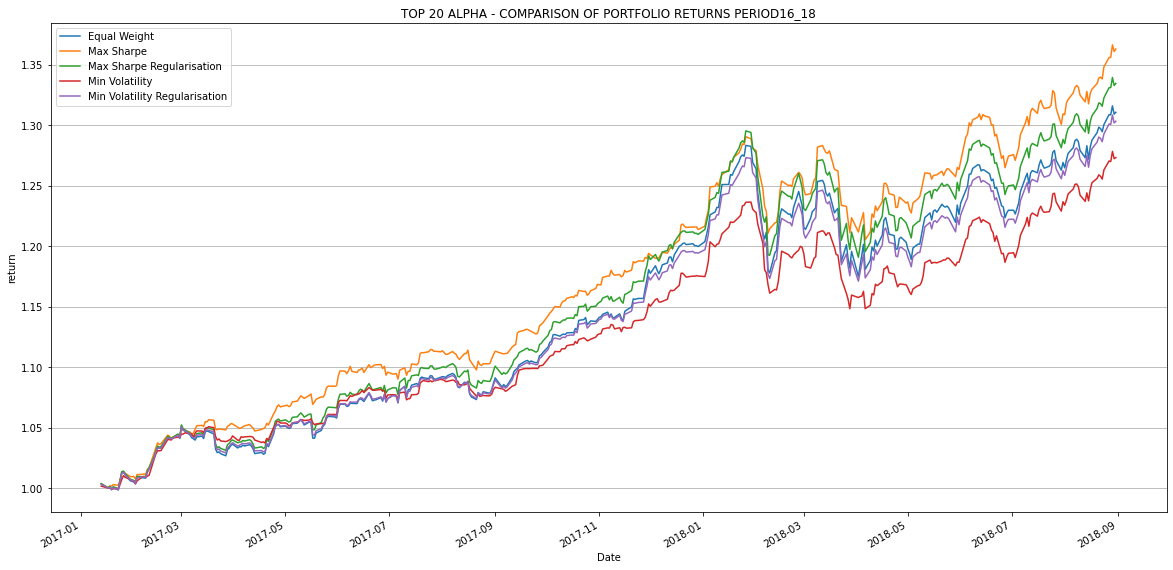

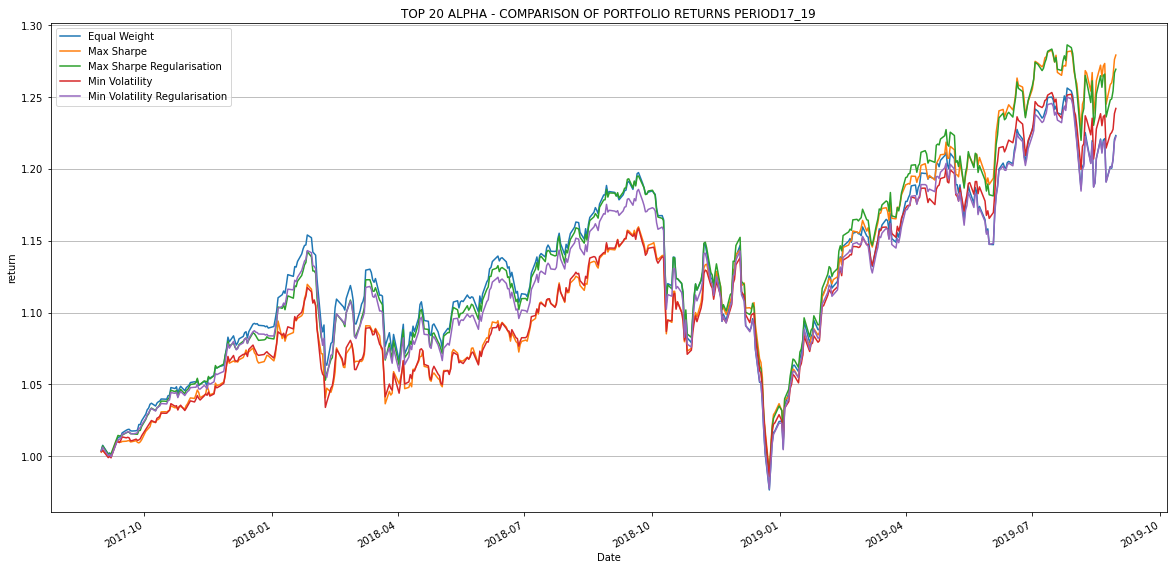

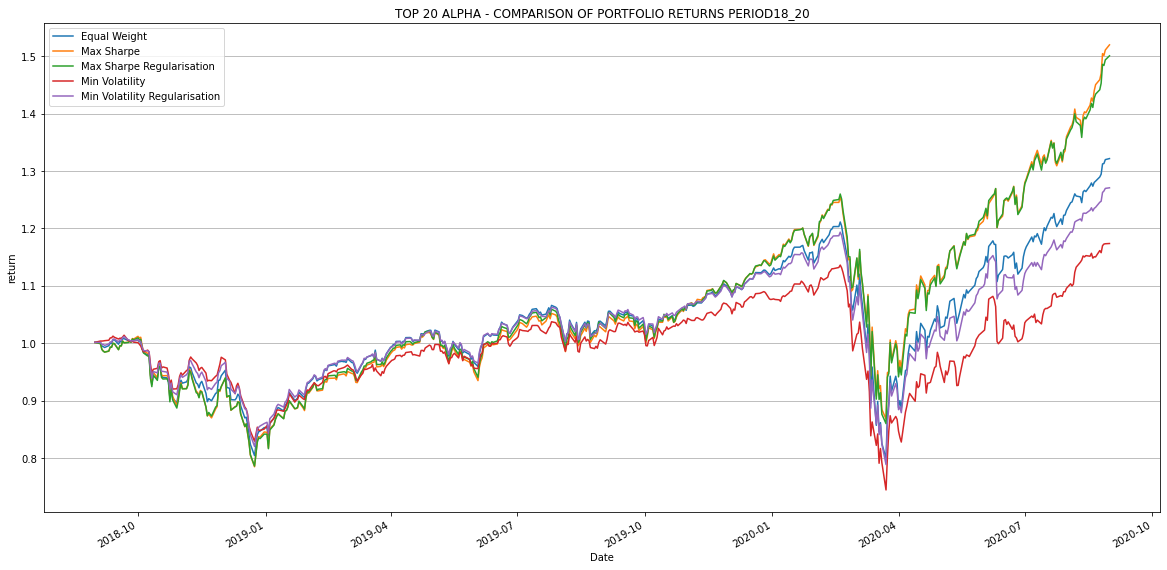

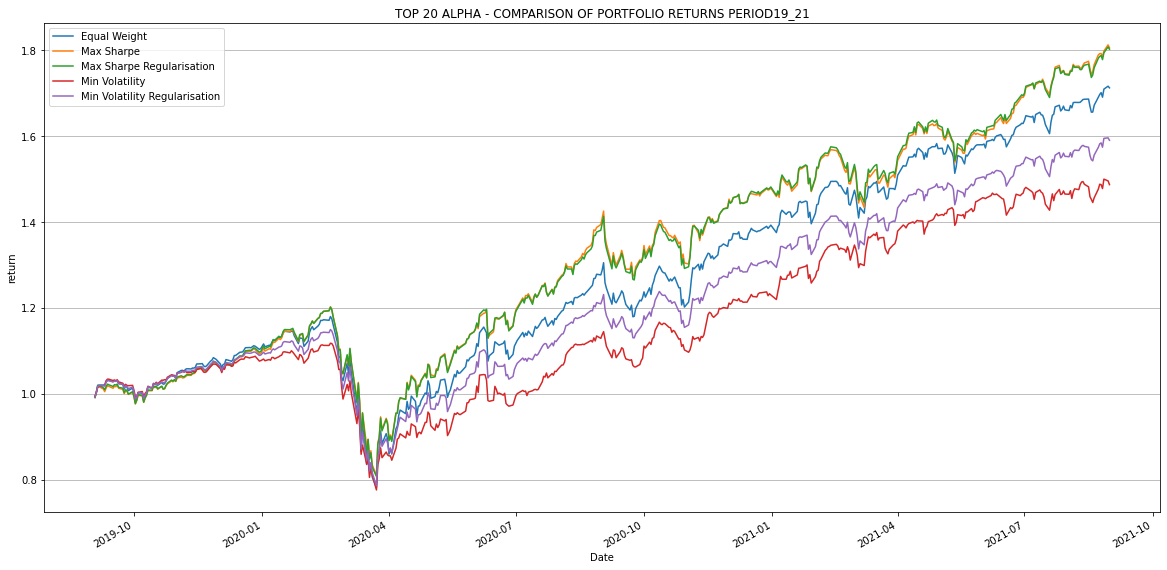

In [46]:
print("TOP 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS FOR EACH PERIOD")

for period_index in range(4):
    # Resize and Rename the graph
    plt.figure(figsize=(20, 10))
    plt.title("TOP 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS " + periods[period_index].upper())

    for portfolio in cum_returns_top20_data[period_index]:
        cum_returns_top20_data[period_index][portfolio].plot().grid(axis='y')

    plt.legend(loc = 'upper left')
    plt.ylabel("return")
    plt.show()

BOTTOM 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS FOR EACH PERIOD


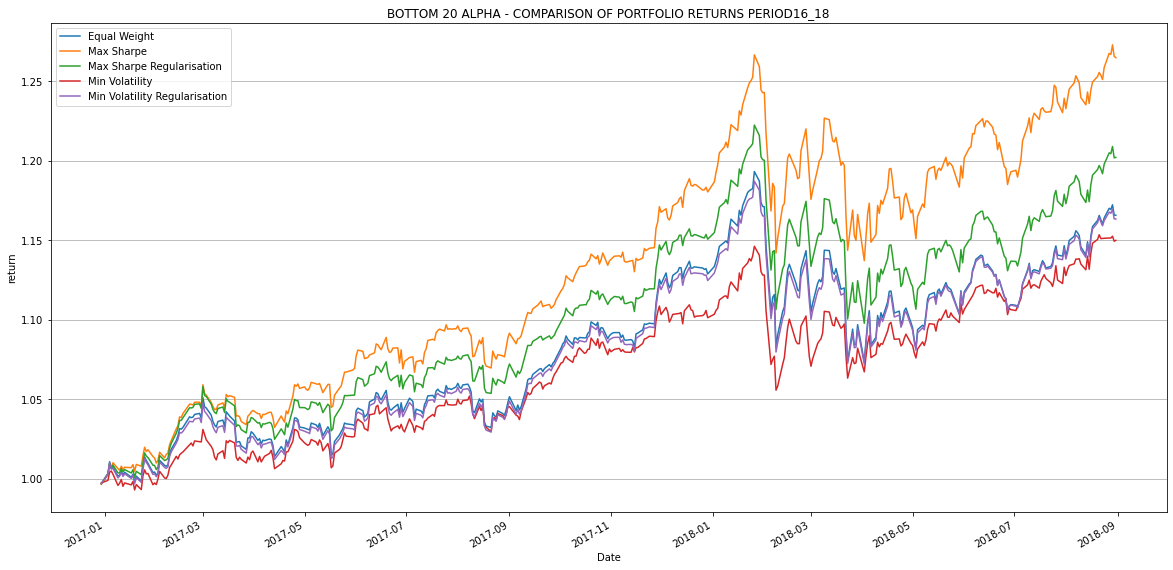

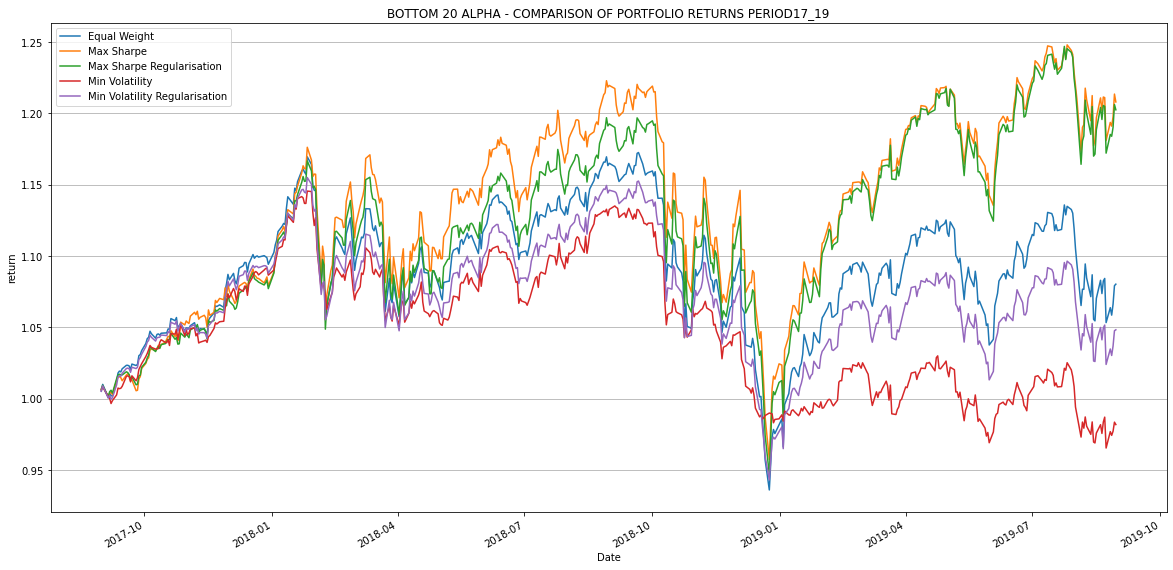

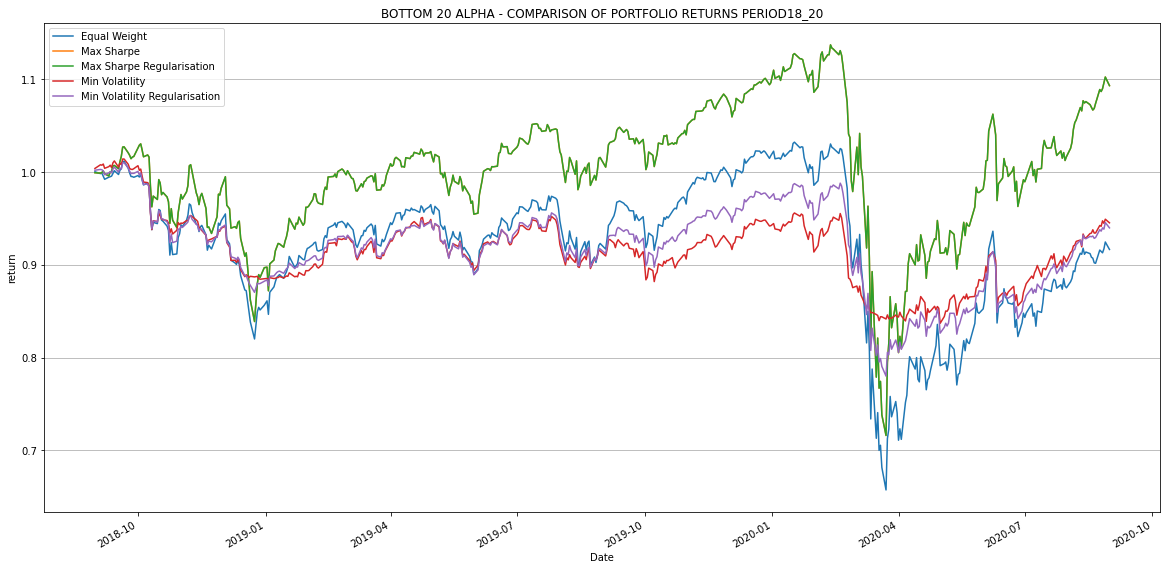

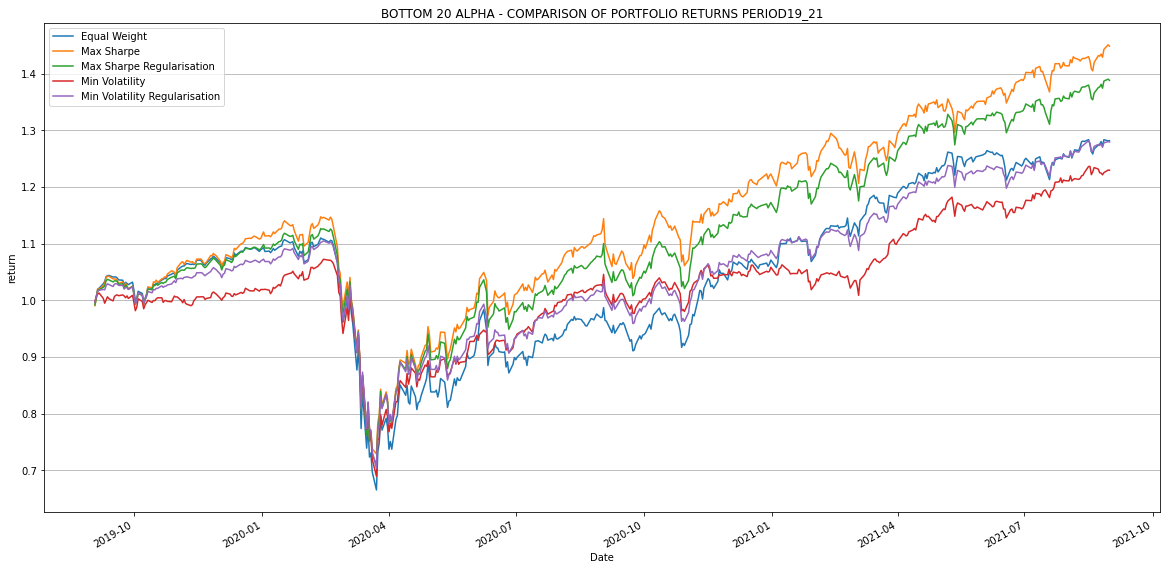

In [47]:
print("BOTTOM 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS FOR EACH PERIOD")

for period_index in range(4):
    # Resize and Rename the graph
    plt.figure(figsize=(20, 10))
    plt.title("BOTTOM 20 ALPHA - COMPARISON OF PORTFOLIO RETURNS " + periods[period_index].upper())

    for portfolio in cum_returns_btm20_data[period_index]:
        cum_returns_btm20_data[period_index][portfolio].plot().grid(axis='y')

    plt.legend(loc = 'upper left')
    plt.ylabel("return")
    plt.show()

## Backtesting

In [48]:
# We now retreive prices for the S&P500 for backtesting 
etf_prices_backtesting_SPY = retreive_refinitiv_data([".SP500"], start_date, end_date)

In [49]:
#etf_prices_backtesting_SPY.to_csv('Data/etf_prices_backtesting_SPY.csv')
etf_prices_backtesting_SPY = pd.read_csv('Data/etf_prices_backtesting_SPY.csv',parse_dates=['Date'], index_col = 'Date')
daily_returns_backtesting_SPY = etf_prices_backtesting_SPY.pct_change()[1:]
#cum_returns_backtesting_SPY = (1 + daily_returns_backtesting_SPY).cumprod()
#print(cum_returns_backtesting_SPY)

In [50]:
#initialise a list which will contain a dataframe of cumulative returns for each period
cum_returns_backtesting = list()

for period_index in range(4):
    
    cum_returns_backtesting.append(pd.DataFrame())

    
    print("USING MAXSHARPE REGULARISATION PORTFOLIO FROM " + periods[period_index].upper() + 
         " TO TEST PERFORMANCE FROM " + period_start_dates_backtesting[period_index] + 
         " TO " + period_end_dates_backtesting[period_index] + "\n")
    
    # Filter the list of returns to only include the top 20 alpha etfs
    etf_returns_top20_tmp = etf_returns[tickers_top_20_dict[periods[period_index]]]
    
    # Filter the list of returns to only include the current time period being evaluated
    etf_returns_top20_tmp = etf_returns_top20_tmp.loc[period_start_dates_backtesting[period_index]: 
                                                      period_end_dates_backtesting[period_index]]
    
    # Call the analyse portfolio function
    # NOTE THAT WE ARE USING THE SAME MAX SHARPE AS PREVIOUSLY (not calculating a new maxsharpe based on the new prices)
    cum_returns = analyse_portfolio(max_sharpe_reg_weights_top20[period_index], etf_returns_top20_tmp, 
                                          "TOP 20 ALPHA - MAX SHARPE REGULARISATION PORTFOLIO")
    
    cum_returns_backtesting[period_index]['TOP 20 ALPHA PORTFOLIO'] = cum_returns
    
    print("")
    
    # Filter the list of returns to only include the bottom 20 alpha etfs
    etf_returns_btm20_tmp = etf_returns[tickers_btm_20_dict[periods[period_index]]]
    
    # Filter the list of returns to only include the current time period being evaluated
    etf_returns_btm20_tmp = etf_returns_btm20_tmp.loc[period_start_dates_backtesting[period_index]: 
                                                      period_end_dates_backtesting[period_index]]

    # Call the analyse portfolio function
    # NOTE THAT WE ARE USING THE SAME MAX SHARPE AS PREVIOUSLY (not calculating a new maxsharpe based on the new prices)    max_sharpe_reg_weights_btm20 = get_max_sharpe_regularisation_weights(etf_prices_btm20_tmp)
    cum_returns = analyse_portfolio(max_sharpe_reg_weights_btm20[period_index], etf_returns_btm20_tmp, 
                                          "BOTTOM 20 ALPHA - MAX SHARPE REGULARISATION")
    
    cum_returns_backtesting[period_index]['BOTTOM 20 ALPHA PORTFOLIO'] = cum_returns
    

    # Conduct a independent t-test on the max sharpe regularisation portfolios 
    # between top 20 alpha and bottom 20 alpha for each time period
    # The null hypothesis is that their mean returns are equal

    # Calculate and print the paired test results
    independent_test_results = pg.ttest(x = etf_returns_top20_tmp.dot(max_sharpe_reg_weights_top20[period_index]), 
                                   y = etf_returns_btm20_tmp.dot(max_sharpe_reg_weights_btm20[period_index]), 
                                   paired = False, alternative = "two-sided",
                                   confidence = 0.95)

    print("\nINDEPENDENT T-TEST RESULTS:\n")
    print(independent_test_results)
    
    # Get the cumulative returns for S&P500 for comparison
    
    cum_returns = (1 + daily_returns_backtesting_SPY.loc[period_start_dates_backtesting[period_index]: 
                                   period_end_dates_backtesting[period_index]]).cumprod()
    cum_returns_backtesting[period_index]['S&P500 PORTFOLIO'] = cum_returns
    
    
    print("\n***************************************\n")


USING MAXSHARPE REGULARISATION PORTFOLIO FROM PERIOD16_18 TO TEST PERFORMANCE FROM 2018-08-31 TO 2019-08-31

TOP 20 ALPHA - MAX SHARPE REGULARISATION PORTFOLIO:

The annual expected portfolio return is: -0.0031518233535258026
The annualised portfolio standard deviation is: 0.15964932978771715
The sharpe ratio of the portfolio is: -0.28281874664656204

The portfolio daily return mean is: -1.2507235529864327e-05
The portfolio daily return  standard deviation is: 0.010056962466581807
The portfolio daily return skewness is: -0.3609715901117015
The portfolio daily return kurtosis is: 2.2944224282322554

BOTTOM 20 ALPHA - MAX SHARPE REGULARISATION:

The annual expected portfolio return is: 0.018747904952135953
The annualised portfolio standard deviation is: 0.14487839906061697
The sharpe ratio of the portfolio is: -0.1604938707124683

The portfolio daily return mean is: 7.439644822276165e-05
The portfolio daily return  standard deviation is: 0.009126481291894434
The portfolio daily return sk

BACKTESTING PORTFOLIO RETURNS FOR EACH PERIOD


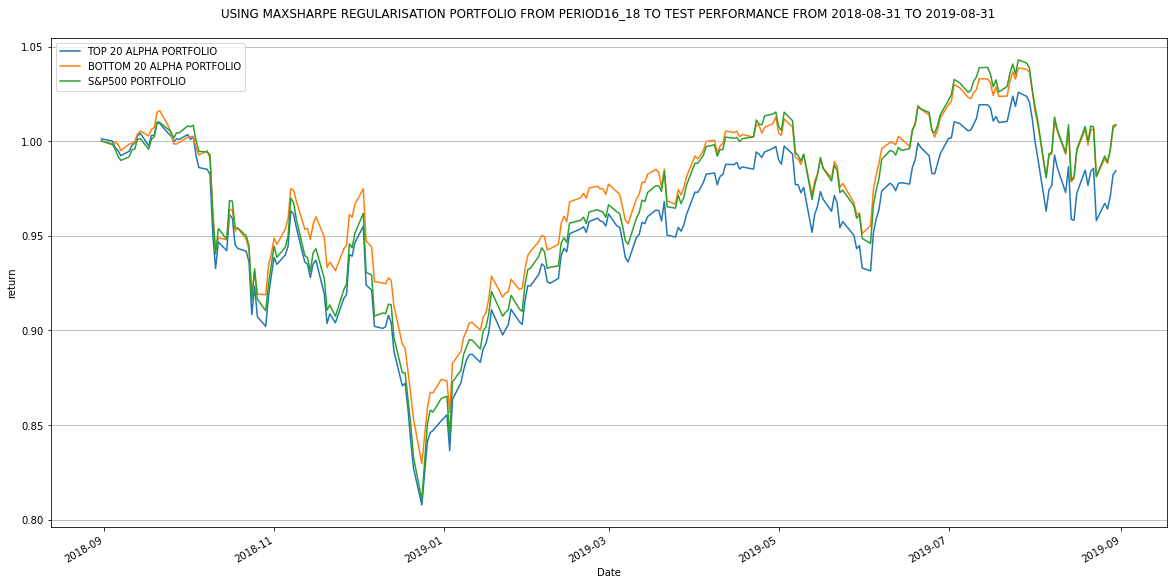

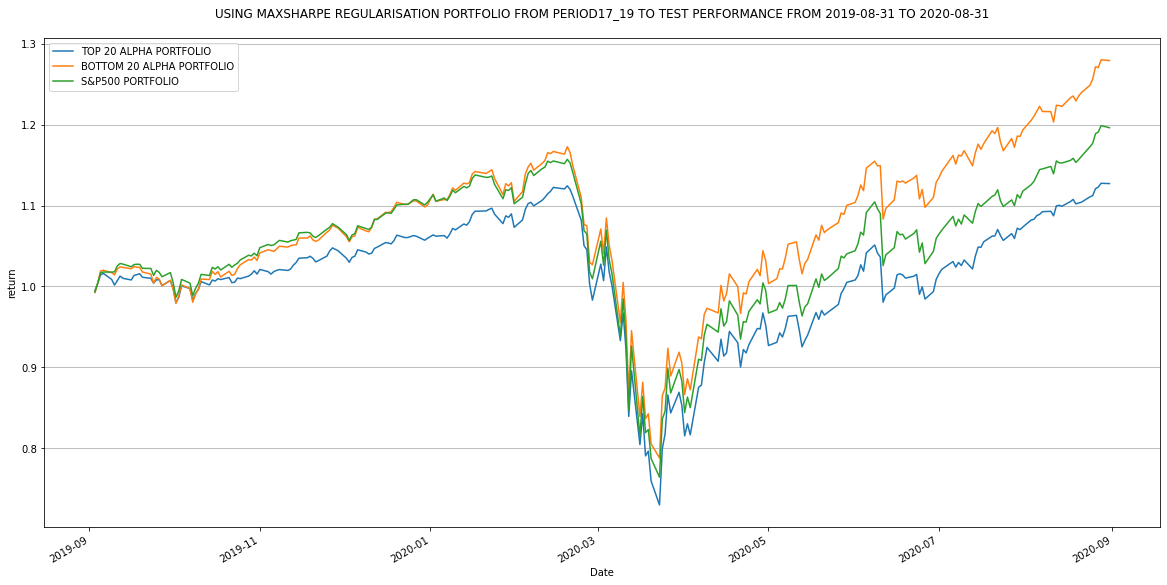

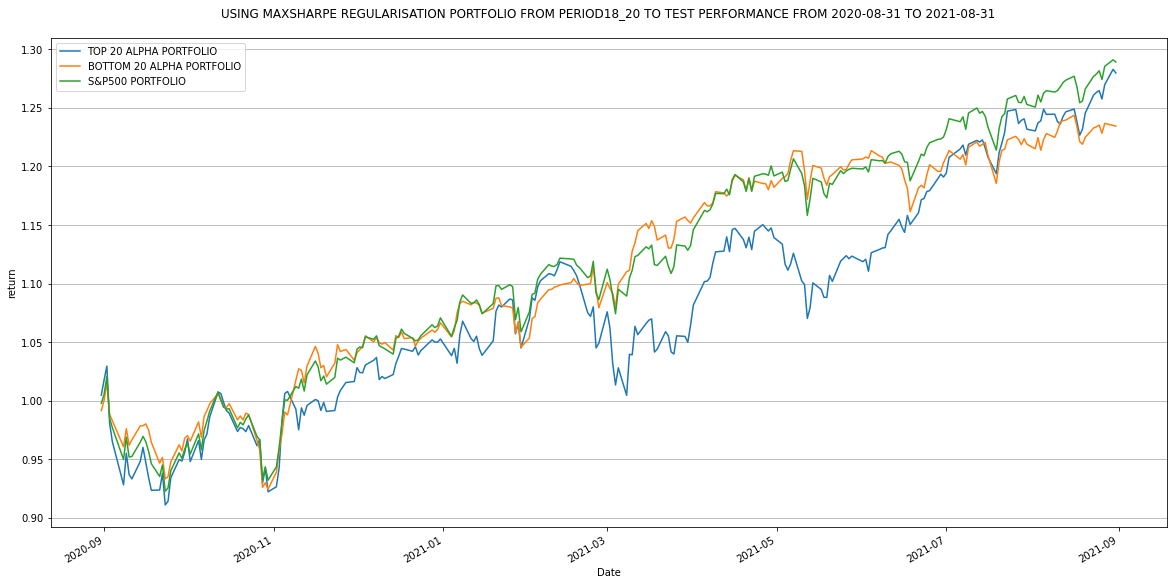

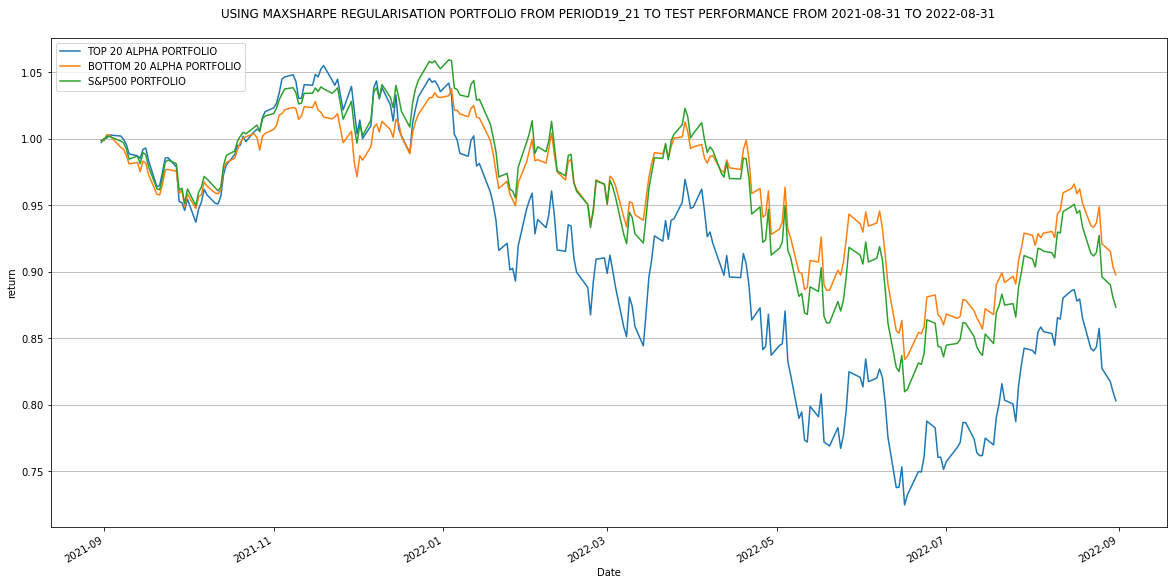

In [51]:
print("BACKTESTING PORTFOLIO RETURNS FOR EACH PERIOD")

for period_index in range(4):
    # Resize and Rename the graph
    plt.figure(figsize=(20, 10))
    plt.title("USING MAXSHARPE REGULARISATION PORTFOLIO FROM " + periods[period_index].upper() + 
         " TO TEST PERFORMANCE FROM " + period_start_dates_backtesting[period_index] + 
         " TO " + period_end_dates_backtesting[period_index] + "\n")

    for portfolio in cum_returns_backtesting[period_index]:
        cum_returns_backtesting[period_index][portfolio].plot().grid(axis='y')

    plt.legend(loc = 'upper left')
    plt.ylabel("return")
    plt.show()